### Setup


The following few sections define packages used and set the environenment (you can ignore them)

In [140]:
# First off - load all python libraries we are going to need
import pandas as pd
import numpy as np
import os
#import plotly.plotly as py
#import plotly.graph_objs as go


from google.colab import auth
from google.cloud import bigquery
from google.colab import files

import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure


from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
!pip install regressors
from regressors import stats    


from sklearn.impute import SimpleImputer

from sklearn import metrics

import statsmodels.api as sm

# !pip install pygam
# from pygam import GAM, s, l , te ,LogisticGAM, LinearGAM

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

# !pip install zepid
# import zepid as zp

#import plotly
#plotly.tools.set_credentials_file(username='harounchahed', api_key='ZHypTc119csyz5p0xWet')

In [0]:
auth.authenticate_user() #This will allow you to authenticate access to BigQuery4/rwDcMzFm8oGoxefjkisvhYNHOGbb11AmM1WbgDorhC0DBQNExxFg1yI

In [0]:
#This is a method that executes a desired SQL query on the database
project_id='ync-capstones'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [143]:
# Now load the data. In general you'd load the whole set of notes but that would take
# several minutes so for this example we're just going to use a subset
#notes = pd.read_csv('D.csv')
cohort = run_query('''
    select * 
    from `NMB.COHORT_BASELINE_P2`
    ''')

SF_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_SF`
    ''')

Treamtment_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_TR`
    ''')

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


# Data Cleaning

## Cohort

In [0]:
cohort = cohort.set_index(['subject_id',	'hadm_id',	'icustay_id'], drop = True)

In [0]:
cohort.mv_starttime = pd.to_datetime(cohort.mv_starttime)
cohort.mv_endtime = pd.to_datetime(cohort.mv_endtime)
cohort.dod = pd.to_datetime(cohort.dod)

In [146]:
cohort

,,,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,,,
10852,139654,253340,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.10,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0
27172,183106,209167,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1
42071,186278,266722,24.50000,2117-08-05 16:00:00,2117-08-06 16:30:00,101.66667,10.0,46.0,NaT,6.3212,85.30,180.00,26.3,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,CATHOLIC,MARRIED,PATIENT DECLINED TO ANSWER,STATUS POST CARDIAC ARREST\CARDIAC CATHETERIZA...,0,34,0,0,0
48925,127507,260855,183.66667,2129-01-22 16:20:00,2129-01-30 08:00:00,71.00000,18.0,68.0,NaT,19.2946,113.40,NaN,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,MARRIED,WHITE,SKULL FRACTURE; HEAD BLEED,0,51,13,0,1
51443,195487,214313,153.25000,2124-03-06 08:00:00,2124-03-12 16:15:00,110.00000,15.0,57.0,2124-11-07,16.8966,201.85,177.80,63.9,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,SINGLE,WHITE,ALTERED MENTAL STATUS,0,38,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42860,160594,219786,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.40,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1
6025,184173,233970,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.00,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1
14858,191758,211210,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.60,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1


In [147]:
cohort.shape # number of patiens
# Sanity check: cohort.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() 

(3820, 23)

In [148]:
# This code fixes few ages that are assigned an age >300 by mistake. We replace these ages with the average age of the dataset.
cohort.loc[cohort.age >= 300, 'age'] = 89

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [0]:
# this code fixes removes unrealistic PEEP values 
cohort = cohort.drop(cohort[cohort.max_peep > 50].index)

In [0]:
cohort["mortality"] = np.where(cohort.dod.notnull(), 1 , 0)

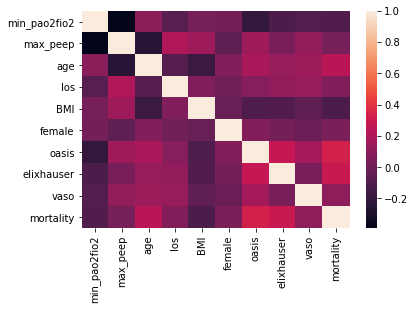

In [151]:
for_cov = cohort[[	"min_pao2fio2",	"max_peep",	"age"	, "los"	, 
                      "BMI"	, "admission_type"	, "admission_location",	
                      "religion" ,	"marital_status",	"ethnicity",	"diagnosis"	,	"female"	, "oasis",
                      "elixhauser",	"vaso",	"mortality"]]
corr = for_cov.corr()
corr_fig = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
#corr_fig.figure.savefig("corr_fig.pdf", bbox_inches='tight', dpi=300)
#files.download("corr_fig.pdf") 

In [152]:
# Dataframe containing only severity and comorbidity scores.
illness = cohort[['oasis', 'elixhauser']]

# Correlation coefficients 
illness.corr()

,oasis,elixhauser
oasis,1.000000,0.277414
elixhauser,0.277414,1.000000


## SF ratios

In [0]:
SF_raw.mv_starttime = pd.to_datetime(SF_raw.mv_starttime)
SF_raw.mv_endtime = pd.to_datetime(SF_raw.mv_endtime)
SF_raw.sf_charttime = pd.to_datetime(SF_raw.sf_charttime)

In [154]:
SF_raw

,subject_id,hadm_id,icustay_id,mv_durations_hours,mv_starttime,mv_endtime,SF_ratio,sf_charttime
0,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.840,2149-11-12 09:00:00
1,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.980,2149-11-11 09:00:00
2,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.940,2149-11-12 12:00:00
3,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.840,2149-11-12 08:00:00
4,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.800,2149-11-12 08:00:00
...,...,...,...,...,...,...,...,...
148623,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,1.980,2181-02-01 05:00:00
148624,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,2.425,2181-02-05 19:00:00
148625,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,1.940,2181-01-31 16:00:00
148626,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,1.980,2181-02-03 04:00:00


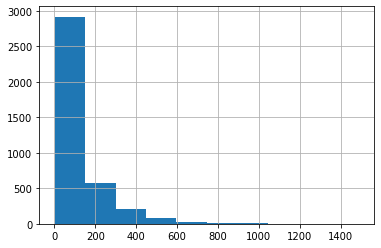

In [155]:
cohort.mv_durations_hours.hist()

In [156]:
SF_raw.subject_id.count() # of SF ratio observations taken within the mechanical ventilation period of our patie

148628

In [157]:
SF_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() # 3748 of 3820 have at least one SF ratio measured

3748

### Treatment

In [0]:
Treamtment_raw.mv_starttime = pd.to_datetime(Treamtment_raw.mv_starttime)
Treamtment_raw.mv_endtime = pd.to_datetime(Treamtment_raw.mv_endtime)
Treamtment_raw.NMBA_timestamp = pd.to_datetime(Treamtment_raw.NMBA_timestamp)

In [159]:
Treamtment_raw.head()

,subject_id,hadm_id,icustay_id,mv_durations_hours,mv_starttime,mv_endtime,NMBA_amount,NMBA_timestamp
0,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,4.701333,2122-02-15 03:40:00
1,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,0.000000,2122-02-15 05:00:00
2,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,NaN,2122-02-15 03:00:00
3,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,NaN,2122-02-15 03:40:00
4,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,7.052000,2122-02-15 03:00:00


In [160]:
Treamtment_raw.icustay_id.count() # of NMBA doses givent within the mechanical ventilation period of our patients

37603

In [161]:
Treamtment_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() # 468 have been given NMBAS

468

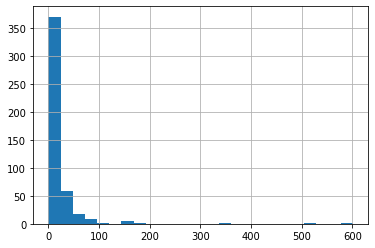

In [162]:
tr_grouped = Treamtment_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size()
freq_of_TR = np.array(tr_grouped) / cohort.mv_durations_hours.loc[tr_grouped.index].divide(24) 
freq_of_TR.hist(bins = 25)

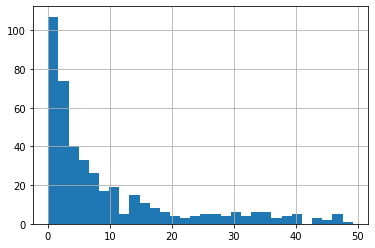

In [163]:
freq_of_TR[freq_of_TR < 50].hist(bins = 30)

In [164]:
freq_of_TR[freq_of_TR < 1].count() # number of people who are treated less than once a day

67

# IPTW

Example of patient who took drug

In [0]:
this_index = (250	,124271	,205951)

In [0]:
# initialize empty dataFrame
  # index
dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
              end = cohort.mv_endtime.loc[this_index],
              freq = 'H' )
  # DataFrame
date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
  # Columns
# date['ID'] = np.full(len(dates_index), this_index)
date['subject_id'] = np.full(len(dates_index), this_index[0])
date['hadm_id'] = np.full(len(dates_index), this_index[1])
date['icustay_id'] = np.full(len(dates_index), this_index[2])
date['SF_ratio'] = np.nan
date['tr_t_min_1'] = np.zeros(len(dates_index))
date['tr_t'] = np.zeros(len(dates_index))
date['death_t'] = np.zeros(len(dates_index))

In [0]:
# fill the SF ratios
for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
  SF_date = row.sf_charttime
  if SF_date in dates_index:
    if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
        date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
    elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
        date.loc[SF_date, 'SF_ratio'] = row.SF_ratio

In [0]:
# fill the treatment history 
for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
  tr_date = row.NMBA_timestamp.floor('h')
  if tr_date in dates_index: 
    date.loc[tr_date, 'tr_t'] = 1
    next_hour = (tr_date + pd.DateOffset(hours=3))
    if next_hour in dates_index:
      date.loc[next_hour, 'tr_t_min_1'] = 1

In [0]:
# Fill in death date 
if pd.notnull(cohort.loc[this_index].dod.date()): 
  # print(cohort.loc[this_index].dod)
  if cohort.loc[this_index].dod.floor('h') in dates_index:
    date.loc[cohort.loc[this_index].dod.floor('h'), 'death_t'] = 1

In [170]:
date

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t
MV_date,,,,,,,
2188-11-12 21:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-12 22:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-12 23:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-13 00:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-13 01:00:00,250,124271,205951,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2188-11-22 18:00:00,250,124271,205951,NaN,1.0,1.0,0.0
2188-11-22 19:00:00,250,124271,205951,NaN,1.0,1.0,0.0
2188-11-22 20:00:00,250,124271,205951,NaN,1.0,0.0,0.0


### IPTW

In [0]:
def reformat(this_index, SF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
                end = cohort.mv_endtime.loc[this_index],
                freq = 'H' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['SF_ratio'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the SF ratios
  for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
    SF_date = row.sf_charttime
    if SF_date in dates_index:
      if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
          date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      # elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
      #     date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.floor('h')
    if tr_date in dates_index: 
      date.loc[tr_date, 'tr_t'] = 1
      next_hour = (tr_date + pd.DateOffset(hours=3))
      if next_hour in dates_index:
        date.loc[next_hour, 'tr_t_min_1'] = 1

  # Fill in death date 
  if pd.notnull(cohort.loc[this_index].dod.date()): 
    # print(cohort.loc[this_index].dod)
    if cohort.loc[this_index].dod.floor('h') in dates_index:
      date.loc[cohort.loc[this_index].dod.floor('h'), 'death_t'] = 1
  return date

In [0]:
PMF_table = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'SF_ratio', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat(index, SF_raw, Treamtment_raw)
  PMF_table = pd.concat([PMF_table, PMF_concat])

In [173]:
PMF_table_full = PMF_table[PMF_table.SF_ratio.notnull()] 
PMF_table_full 

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t
MV_date,,,,,,,
2127-04-27 16:00:00,10852,139654,253340,1.371429,0.0,0.0,0.0
2127-04-27 18:00:00,10852,139654,253340,1.900000,0.0,0.0,0.0
2127-04-27 19:00:00,10852,139654,253340,1.920000,0.0,0.0,0.0
2127-04-28 01:00:00,10852,139654,253340,2.450000,0.0,0.0,0.0
2127-04-28 04:00:00,10852,139654,253340,2.400000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2109-12-13 14:00:00,6025,184173,233970,2.425000,0.0,0.0,0.0
2133-04-10 16:00:00,14858,191758,211210,2.000000,0.0,0.0,0.0
2133-04-10 17:00:00,14858,191758,211210,1.900000,0.0,0.0,0.0


In [0]:
#PMF_table_full = PMF_table_full.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24) # remember to delete this if it doesn't work!!!!!

In [233]:
y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=PMF_table_full, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.054357
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                75896
Model:                          Logit   Df Residuals:                    75893
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Mar 2020   Pseudo R-squ.:                  0.6306
Time:                        08:25:23   Log-Likelihood:                -4125.5
converged:                       True   LL-Null:                       -11170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4972      0.154     -9.727      0.000      -1.799      -1.195
SF_ratio      -1.8306      0.

In [234]:
nom_table = PMF_table.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + vaso + explicit_sepsis', data = nom_table, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.039802
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:               418048
Model:                          Logit   Df Residuals:                   418040
Method:                           MLE   Df Model:                            7
Date:                Tue, 17 Mar 2020   Pseudo R-squ.:                  0.6194
Time:                        08:25:29   Log-Likelihood:                -16639.
converged:                       True   LL-Null:                       -43715.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.1218      0.109    -47.138      0.000      -5.335      -4.909
tr_t_min_1   

In [0]:
# nom_table = PMF_table.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
# nom_table_full = nom_table[pd.notnull(nom_table.SF_ratio)]
# y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + vaso + explicit_sepsis', data = nom_table_full, return_type='dataframe')
# logit_model_nom = sm.Logit(y,X)
# fitted_model_nom = logit_model_nom.fit()
# print(fitted_model_nom.summary())

In [0]:
def IPTW(logit_model_nom, logit_model_den, this_index, den_table, nom_table): 
  # denominator
  den_table_this_index = den_table[(den_table.subject_id == this_index[0]) & (den_table.hadm_id == this_index[1]) & (den_table.icustay_id == this_index[2])]
  X_den = den_table_this_index[['SF_ratio',  'tr_t_min_1']]
  X_den = sm.add_constant(X_den, has_constant='add')
  p_den = logit_model_den.predict(X_den)
  den = np.where(den_table_this_index.tr_t == 1 , p_den, 1 - p_den).prod()

  # nominator
  nom_table_this_index = nom_table[(nom_table.subject_id == this_index[0]) & (nom_table.hadm_id == this_index[1]) & (nom_table.icustay_id == this_index[2])]
  X_nom = nom_table_this_index[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso', 'explicit_sepsis']]
  X_nom = sm.add_constant(X_nom, has_constant='add')
  p_nom = logit_model_nom.predict(X_nom)
  nom = np.where(nom_table_this_index.tr_t == 1 , p_nom, 1 - p_nom).prod()
  
  #result = nom / den
  return nom, den

In [0]:
IPTW_table = pd.DataFrame(index = cohort.index, columns = ['nom', 'den', 'IPTW'])

In [180]:
for index in cohort.index: 
  IPTW_table.loc[index].nom, IPTW_table.loc[index].den = IPTW(fitted_model_nom, fitted_model_den, index, PMF_table_full, nom_table)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [181]:
this_index = (3417,	101256,	268184) # treated
IPTW(fitted_model_nom, fitted_model_den, this_index, PMF_table_full, nom_table)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(1.4447305034316394e-46, 1.1059554615154136e-15)

In [182]:
this_index = (250	,124271	,205951) # treated
IPTW(fitted_model_nom, fitted_model_den, this_index, PMF_table_full, nom_table)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(4.8309157550134e-33, 0.00120777826415885)

In [183]:
this_index = (9,	150750,	220597) # not treated
IPTW(fitted_model_nom, fitted_model_den, this_index, PMF_table_full, nom_table)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(0.42022358880840466, 1.0)

In [184]:
IPTW_table.IPTW = IPTW_table.nom / IPTW_table.den
IPTW_table

,,,nom,den,IPTW
subject_id,hadm_id,icustay_id,,,
10852,139654,253340,0.960291,0.955072,1.00546
27172,183106,209167,0.359648,0.772325,0.465669
42071,186278,266722,0.924355,0.913115,1.01231
48925,127507,260855,0.412912,1,0.412912
51443,195487,214313,0.692364,0.784821,0.882193
...,...,...,...,...,...
42860,160594,219786,0.968317,0.986808,0.981262
6025,184173,233970,0.982136,0.985928,0.996154
14858,191758,211210,0.969861,0.987463,0.982174


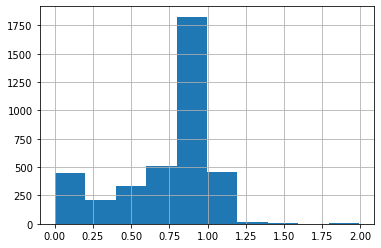

In [185]:
IPTW_table.IPTW.hist() # total is 3820 rows × 1 columns

{'boxes': [<matplotlib.lines.Line2D at 0x7fef917daba8>],
 'caps': [<matplotlib.lines.Line2D at 0x7fef917e27f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fef917e94a8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fef917e9080>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fef917daef0>,
  <matplotlib.lines.Line2D at 0x7fef917e2320>]}

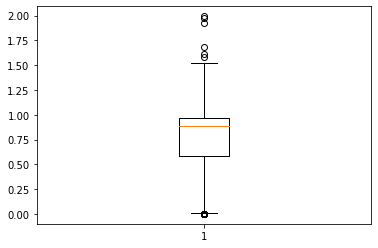

In [186]:
plt.boxplot(IPTW_table.IPTW)

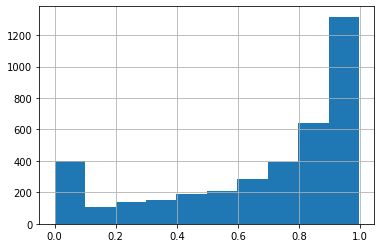

In [187]:
IPTW_table.nom.hist() # total is 3820 rows × 1 columns

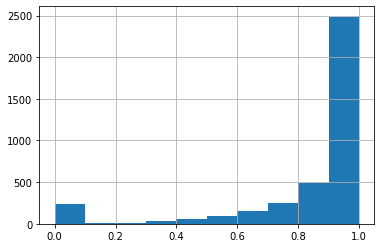

In [188]:
IPTW_table.den.hist() # total is 3820 rows × 1 columns

# MSM

In [189]:
cohort.shape 

(3820, 24)

In [190]:
IPTW_table.shape

(3820, 3)

In [191]:
PMF_table.shape

(418048, 7)

In [0]:
cohort_with_weight = cohort.merge(IPTW_table, left_index=True, right_index=True)

In [0]:
MSM_table = PMF_table.merge(cohort_with_weight, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])

In [194]:
MSM_table.shape

(418048, 34)

In [0]:
# MSM_table.to_csv('MSM_table.csv')

In [0]:
# files.download('MSM_table.csv') 
# MSM_table

In [197]:
MSM_table

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,nom,den,IPTW
0,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
1,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
2,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
3,10852,139654,253340,1.371429,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
4,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418043,84717,134774,234116,NaN,0.0,0.0,0.0,2.0,2104-09-21 05:00:00,2104-09-21 07:00:00,76.0,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.988936,0.996374,0.992535
418044,84717,134774,234116,2.250000,0.0,0.0,0.0,2.0,2104-09-21 05:00:00,2104-09-21 07:00:00,76.0,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.988936,0.996374,0.992535
418045,54936,131505,250712,NaN,0.0,0.0,0.0,2.5,2107-02-11 04:00:00,2107-02-11 06:30:00,80.0,8.0,83.0,2107-02-16,5.7031,102.3,185.0,29.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ACUTE MYOCARDISAL INFARCTION,0,44,10,0,1,1,0.989602,0.994282,0.995293
418046,54936,131505,250712,NaN,0.0,0.0,0.0,2.5,2107-02-11 04:00:00,2107-02-11 06:30:00,80.0,8.0,83.0,2107-02-16,5.7031,102.3,185.0,29.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ACUTE MYOCARDISAL INFARCTION,0,44,10,0,1,1,0.989602,0.994282,0.995293


## Investigating Weights

In [198]:
MSM_table[MSM_table.tr_t == 1].IPTW.mean()

0.00013370763291885797

In [199]:
MSM_table[MSM_table.tr_t == 0].IPTW.mean()

0.481494634894148

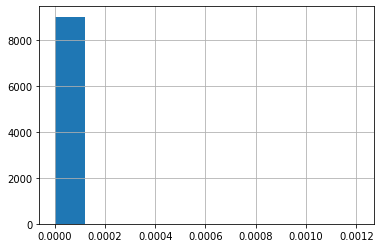

In [200]:
MSM_table[MSM_table.tr_t == 1].nom.hist()

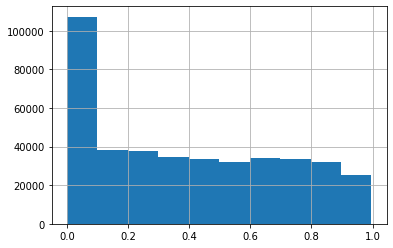

In [201]:
MSM_table[MSM_table.tr_t == 0].nom.hist()

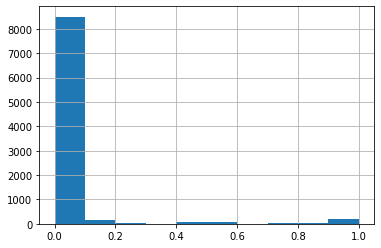

In [202]:
MSM_table[MSM_table.tr_t == 1].den.hist()

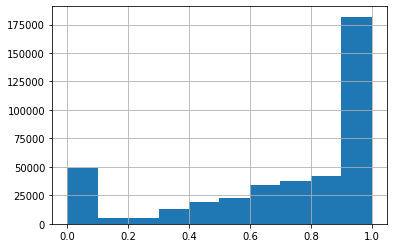

In [203]:
MSM_table[MSM_table.tr_t == 0].den.hist()

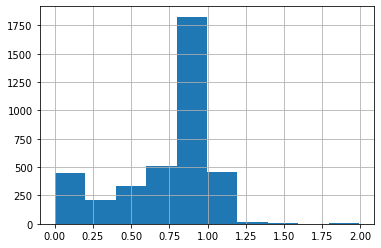

In [204]:
# investigation for cohort starts here 
cohort_with_NMBA = MSM_table.groupby(by = ['subject_id', 'hadm_id', 'icustay_id']).max()
cohort_with_NMBA.IPTW.hist()

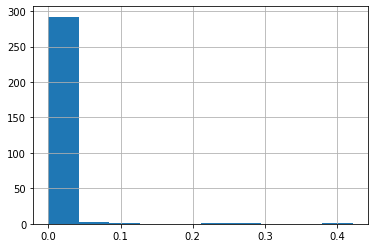

In [205]:
cohort_with_NMBA[cohort_with_NMBA.tr_t == 1].IPTW.hist()

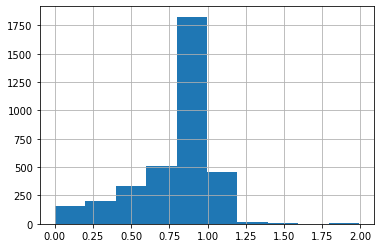

In [206]:
cohort_with_NMBA[cohort_with_NMBA.tr_t == 0].IPTW.hist()

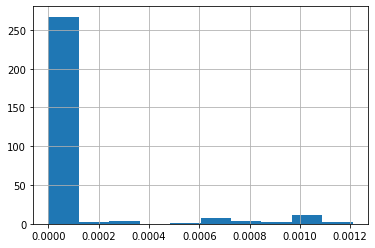

In [207]:
cohort_with_NMBA[cohort_with_NMBA.tr_t == 1].nom.hist()

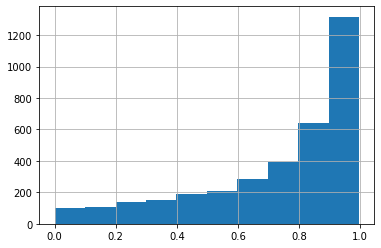

In [208]:
cohort_with_NMBA[cohort_with_NMBA.tr_t == 0].nom.hist()

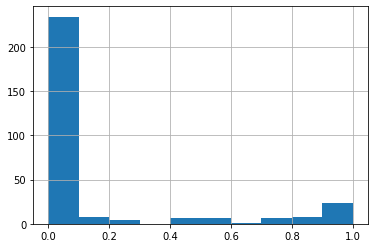

In [209]:
cohort_with_NMBA[cohort_with_NMBA.tr_t == 1].den.hist()

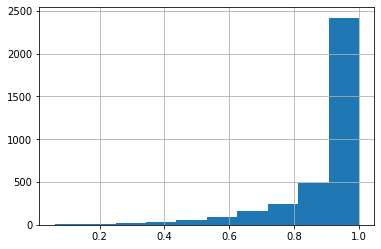

In [210]:
cohort_with_NMBA[cohort_with_NMBA.tr_t == 0].den.hist()

## final MSM

In [211]:
X = MSM_table[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso']] # add sepsis and BMI
y = MSM_table['death_t']

# Instantiate a binomial family model with the logit function.
# MSM_model = sm.GLM(y, X, family=sm.families.Binomial(), links = sm.genmod.families.links.logit)
MSM_model = sm.GLM(y, X, family=sm.families.Binomial(),  links = sm.genmod.families.links.logit)

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:               418048
Model:                            GLM   Df Residuals:                   418042
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3712.6
Date:                Tue, 17 Mar 2020   Deviance:                       7425.1
Time:                        08:24:25   Pearson chi2:                 3.04e+06
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tr_t_min_1     0.6892      0.211      3.265      0.0

In [212]:
X = MSM_table[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso']]
y = MSM_table['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:               418048
Model:                            GLM   Df Residuals:                196915.93
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2182.5
Date:                Tue, 17 Mar 2020   Deviance:                       4365.1
Time:                        08:24:28   Pearson chi2:                 1.11e+06
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tr_t_min_1    -4.7737    470.926     -0.010      0.9

# MSM last 24 hours

In [213]:
cohort.shape 

(3820, 24)

In [214]:
IPTW_table.shape

(3820, 3)

In [215]:
PMF_table.shape

(418048, 7)

In [0]:
cohort_with_weight = cohort.merge(IPTW_table, left_index=True, right_index=True)

In [0]:
MSM_table = PMF_table.merge(cohort_with_weight, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])

In [218]:
MSM_table.shape

(418048, 34)

In [0]:
MSM_table_24 = MSM_table.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24)

In [0]:
# MSM_table.to_csv('MSM_table.csv')

In [0]:
# files.download('MSM_table.csv') 
# MSM_table

In [222]:
MSM_table

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,nom,den,IPTW
0,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
1,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
2,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
3,10852,139654,253340,1.371429,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
4,10852,139654,253340,NaN,0.0,0.0,0.0,23.6,2127-04-27 13:00:00,2127-04-28 12:36:00,150.0,11.0,62.0,NaT,3.3713,128.1,165.1,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960291,0.955072,1.00546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418043,84717,134774,234116,NaN,0.0,0.0,0.0,2.0,2104-09-21 05:00:00,2104-09-21 07:00:00,76.0,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.988936,0.996374,0.992535
418044,84717,134774,234116,2.250000,0.0,0.0,0.0,2.0,2104-09-21 05:00:00,2104-09-21 07:00:00,76.0,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.988936,0.996374,0.992535
418045,54936,131505,250712,NaN,0.0,0.0,0.0,2.5,2107-02-11 04:00:00,2107-02-11 06:30:00,80.0,8.0,83.0,2107-02-16,5.7031,102.3,185.0,29.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ACUTE MYOCARDISAL INFARCTION,0,44,10,0,1,1,0.989602,0.994282,0.995293
418046,54936,131505,250712,NaN,0.0,0.0,0.0,2.5,2107-02-11 04:00:00,2107-02-11 06:30:00,80.0,8.0,83.0,2107-02-16,5.7031,102.3,185.0,29.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ACUTE MYOCARDISAL INFARCTION,0,44,10,0,1,1,0.989602,0.994282,0.995293


In [223]:
MSM_table_24[MSM_table_24.tr_t == 1].IPTW.mean()

0.00046061712957605895

In [224]:
MSM_table_24[MSM_table_24.tr_t == 0].IPTW.mean()

0.7167625241010703

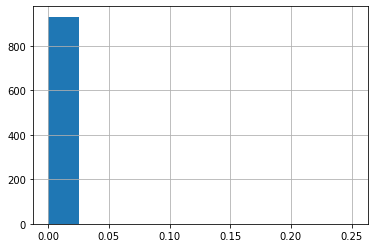

In [225]:
MSM_table_24[MSM_table_24.tr_t == 1].IPTW.hist()

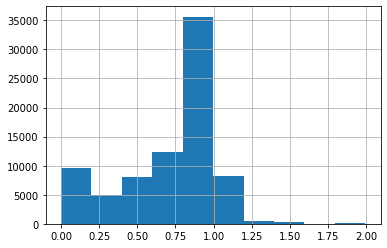

In [226]:
MSM_table_24[MSM_table_24.tr_t == 0].IPTW.hist()

In [227]:
MSM_table_SF = MSM_table[pd.notnull(MSM_table.SF_ratio)]
MSM_table_SF.shape

(75896, 34)

In [228]:
X = MSM_table_24[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso']] # add sepsis and BMI
y = MSM_table_24['death_t']

# Instantiate a binomial family model with the logit function.
# MSM_model = sm.GLM(y, X, family=sm.families.Binomial(), links = sm.genmod.families.links.logit)
MSM_model = sm.GLM(y, X, family=sm.families.Binomial(),  links = sm.genmod.families.links.logit)

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                80601
Model:                            GLM   Df Residuals:                    80595
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2593.6
Date:                Tue, 17 Mar 2020   Deviance:                       5187.1
Time:                        08:24:30   Pearson chi2:                 2.78e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tr_t_min_1     1.1364      0.242      4.699      0.0

In [229]:
X = MSM_table_24[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso']]
y = MSM_table_24['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_24.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                80601
Model:                            GLM   Df Residuals:                 57096.75
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1669.3
Date:                Tue, 17 Mar 2020   Deviance:                       3338.6
Time:                        08:24:30   Pearson chi2:                 2.07e+05
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tr_t_min_1    -7.8128   1645.392     -0.005      0.9

In [0]:
 from statsmodels.gam.tests.test_penalized import df_autos
 from statsmodels.gam.api import GLMGam, BSplines

In [231]:
x_spline = df_autos[['weight', 'hp']]
bs = BSplines(x_spline, df=[12, 10], degree=[3, 3])
alpha = np.array([21833888.8, 6460.38479])
gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos, smoother=bs, alpha=alpha)
res_bs = gam_bs.fit()
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   189.13
Model Family:                Gaussian   Df Model:                        12.87
Link Function:               identity   Scale:                          4.8825
Method:                         PIRLS   Log-Likelihood:                -441.81
Date:                Tue, 17 Mar 2020   Deviance:                       923.45
Time:                        08:24:30   Pearson chi2:                     923.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.9923      1.997     26.034   